In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import scipy
import shap
import lime

from utils import utils
import utils.efinet as efinet
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
import tensorflow as tf

# import cuml

# Plot settings
fpath = "C:/Users/Marek/OneDrive/School/DP/masters-thesis/assets/figures/merged"
# plt.rcParams["font.family"] = ["Latin Modern Roman"]
plt.rcParams["figure.figsize"] = (5, 5)
# plt.rcParams["savefig.dpi"] = 300
# plt.rcParams["font.size"] = 20

In [10]:
# Load labels
with open("../data/Merged/CLAS_merged_5s.pkl", "rb") as f:
    clas_labels = pickle.load(f)
clas_labels = clas_labels["label"]
clas_labels[clas_labels == 1] = 10
clas_labels[clas_labels == 3] = 1
clas_labels[clas_labels == 6] = 1
clas_labels[clas_labels == 8] = 1
idx = clas_labels.isin([0, 1])
clas_labels = clas_labels[idx]

# Load and concat data
with open("../data/GADF_Data/GADF_CLAS_merged_5s.pkl", "rb") as f:
    clas_gadf = pickle.load(f)

clas_gcn = scipy.io.loadmat("../data/GCN_Data/GCN_CLAS_Standard_5s.mat")
clas_gcn = np.transpose(clas_gcn["cause5s"], (0, 2, 3, 1))

L = len(clas_gcn)

clas_result = []
for i in range(L):
    clas_result.append(clas_gcn[i] + clas_gadf[i])

clas_data = np.array(clas_result)[idx]

print("Data shape: ", np.shape(clas_data))
print("Counts: \n", pd.value_counts(clas_labels))

Data shape:  (7602, 32, 32, 3)
Counts: 
 1    6964
0     638
Name: label, dtype: int64


In [11]:
# Load labels
with open("../data/Merged/WESAD_merged_5s.pkl", "rb") as f:
    wesad_labels = pickle.load(f)
wesad_labels = wesad_labels["model_label"]

# Load and concat data
with open("../data/GADF_Data/GADF_WESAD_merged_5s.pkl", "rb") as f:
    wesad_gadf = pickle.load(f)

wesad_gcn = scipy.io.loadmat("../data/GCN_Data/GCN_WESAD_Standard_5s.mat")
wesad_gcn = np.transpose(wesad_gcn["cause5s"], (0, 2, 3, 1))

L = len(wesad_gcn)

wesad_result = []
for i in range(L):
    wesad_result.append(wesad_gcn[i] + wesad_gadf[i])

wesad_data = np.array(wesad_result)

print("Data shape: ", np.shape(wesad_data))
print("Counts: \n", pd.value_counts(wesad_labels))

Data shape:  (4520, 32, 32, 3)
Counts: 
 0    3519
1    1001
Name: model_label, dtype: int64


In [46]:
data = np.concatenate((clas_gadf[idx], wesad_gadf), axis=0)
labels = np.concatenate((clas_labels, wesad_labels), axis=0)

print("Data shape: ", np.shape(data))
print("Counts: \n", pd.value_counts(labels))

Data shape:  (12122, 32, 32, 3)
Counts: 
 1    7965
0    4157
dtype: int64


In [47]:
# Split data into train and test
X, y = data, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

(9697, 32, 32, 3) (2425, 32, 32, 3) (9697,) (2425,)


In [48]:
train_model, eval_model = efinet.build_graph([32, 32, 3], 2, verbose=False)
train_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                    loss=[efinet.marginLoss, 'mse'],
                    loss_weights=[1., 0.392],
                    metrics={'Efficient_CapsNet': 'accuracy'})

#with tf.device('/cpu:0'):
history = train_model.fit([X_train, y_train], [y_train, X_train], batch_size=256, epochs=30,
                          validation_data=[[X_test, y_test], [y_test, X_test]])







Epoch 1/30
38/38 [==============================] - 2s 26ms/step - loss: 0.3971 - Efficient_CapsNet_loss: 0.2139 - Generator_loss: 0.4673 - Efficient_CapsNet_accuracy: 0.6664 - val_loss: 0.4237 - val_Efficient_CapsNet_loss: 0.2657 - val_Generator_loss: 0.4032 - val_Efficient_CapsNet_accuracy: 0.6709
Epoch 2/30
38/38 [==============================] - 1s 16ms/step - loss: 0.2683 - Efficient_CapsNet_loss: 0.1116 - Generator_loss: 0.3998 - Efficient_CapsNet_accuracy: 0.8384 - val_loss: 0.3452 - val_Efficient_CapsNet_loss: 0.1886 - val_Generator_loss: 0.3997 - val_Efficient_CapsNet_accuracy: 0.8474
Epoch 3/30
38/38 [==============================] - 1s 17ms/step - loss: 0.2393 - Efficient_CapsNet_loss: 0.0826 - Generator_loss: 0.3997 - Efficient_CapsNet_accuracy: 0.8916 - val_loss: 0.3182 - val_Efficient_CapsNet_loss: 0.1616 - val_Generator_loss: 0.3995 - val_Efficient_CapsNet_accuracy: 0.8458
Epoch 4/30
38/38 [==============================] - 1s 16ms/step - loss: 0.2293 - Efficient

In [32]:
# model_name = "Merged_5s"
# lr = 5e-4
# epochs = 100
# batch_size = 256
#
# # Train model
# train_model, eval_model = efinet.build_graph([32, 32, 3], 2, verbose=False)
# trained_model = efinet.train(model=train_model, data=((X_train, y_train), (X_test, y_test)),
#                              epochs=epochs, lr=lr, model_name=model_name, batch_size=batch_size)

In [49]:
print("Train acc: ", np.round(np.max(history.history["Efficient_CapsNet_accuracy"]), 4))
print("Val acc: ", np.round(np.max(history.history["val_Efficient_CapsNet_accuracy"]), 4))

Train acc:  0.9713
Val acc:  0.9159


Accuracy = 0.9142268041237114
F1 Score = 0.9019854742628313
TPR = 0.9214063225726823
TNR =  0.8889283583789731
AUC = 0.9408796999919063


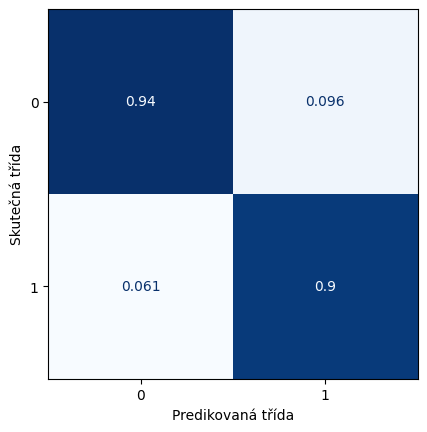

In [50]:
eval_model.load_weights(f"../results/models/Merged_5s.h5")

# Predict the values from the validation dataset
Y_pred = eval_model.predict(X_test)

utils.print_stats(y_test, Y_pred)
utils.plot_confusion_matrix(y_test, Y_pred, normalize="pred")
# plt.savefig(f"{fpath}/merged_5s.pdf", format="pdf", bbox_inches="tight")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


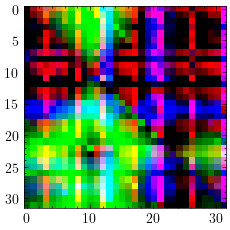

In [53]:
plt.imshow(X_test[0])

In [112]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(X[100].astype("double"), eval_model.predict)
print(y[100])

  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: Calling `Model.predict` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.predict` with eager mode enabled.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


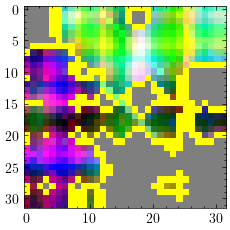

In [89]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=1, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

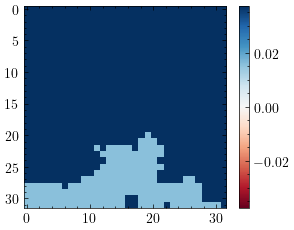

In [81]:


#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()